In [1]:
import torch
import gpytorch

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import VariationalStrategyDecoupledConditionals

In [2]:
from uci_data import load_uci_data

torch.manual_seed(0)
device = "cuda:1"

torch.set_default_dtype(torch.float64)

In [3]:
class SVGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points,
            variational_distribution, learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        # self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class DCSVGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        covar_module_mean = gpytorch.kernels.RBFKernel()
        variational_strategy = VariationalStrategyDecoupledConditionals(
            self, inducing_points,
            variational_distribution,
            covar_module_mean,
            learn_inducing_locations=True,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        # self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
import os
import sys
sys.path.append("./PyTorch-LBFGS/functions")

from LBFGS import LBFGS, FullBatchLBFGS

def train(
    model, likelihood, train_x, train_y, test_x, test_y,
    num_epochs=1000, lr=0.01):

    optimizer = FullBatchLBFGS(list(model.parameters()) + list(likelihood.parameters()))
    # optimizer = FullBatchLBFGS(model.parameters())
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0), beta=1.)

    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        return loss

    loss = closure()
    loss.backward()

    for i in range(num_epochs):
#         if i == 56:
#             import ipdb; ipdb.set_trace()

        options = {'closure': closure, 'current_loss': loss, 'max_ls': 50}
        loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(options)

        with torch.no_grad():
            # train_rmse, train_nll = evaluate(model, likelihood, train_x, train_y)
            test_rmse, test_nll = evaluate(model, likelihood, test_x, test_y)

            if i % 10 == 0:
                print(
                    "iter {:4d},".format(i),
                    "loss {:f},".format(loss.item()),
                    "mean ls {:.4f},".format(model.variational_strategy.covar_module_mean.lengthscale.item()) if isinstance(model, DCSVGP) else "",
                    "covar ls {:.4f},".format(model.covar_module.lengthscale.item()),
                    "noise {:.4f},".format(likelihood.noise.item()),
                    "test rmse {:.4f},".format(test_rmse),
                    "test nll {:.4f}".format(test_nll),
                )

    return model, likelihood

def evaluate(model, likelihood, test_x, test_y):
    model.eval()
    likelihood.eval()

    pred_dist = likelihood(model(test_x))

    rmse = (pred_dist.mean - test_y).square().mean().sqrt()
    nll = -pred_dist.log_prob(test_y) / test_y.size(0)

    model.train()
    likelihood.train()
    return rmse, nll

In [5]:
train_x, train_y, test_x, test_y = load_uci_data("./uci/", "elevators", seed=0, device=device)[:4]

u0 = torch.randn(500, train_x.size(-1), device=device) * 0.1
model = DCSVGP(u0)
# model = SVGP(u0)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

print(list(model.parameters())[0].dtype)
model.to(device).train()
likelihood.to(device).train()

train(model, likelihood, train_x, train_y, test_x, test_y, num_epochs=200, lr=1.)

DCSVGP
torch.float64


/home/kaiwen/better_init_variational_gp/gpytorch/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/kaiwen/better_init_variational_gp/dcsvgp/./PyTorch-LBFGS/functions/LBFGS.py:257: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


iter    0, loss 1.703794, mean ls 0.5188, covar ls 0.8876, noise 1.0883, test rmse 1.0144, test nll 1.1434
iter   10, loss 1.372528, mean ls 0.4440, covar ls 4.5641, noise 0.9635, test rmse 0.9379, test nll 1.2148
iter   20, loss 1.111880, mean ls 0.6841, covar ls 11.3551, noise 0.5196, test rmse 0.6478, test nll 0.8994
iter   30, loss 0.991113, mean ls 0.7627, covar ls 15.9900, noise 0.3775, test rmse 0.5579, test nll 0.7749
iter   40, loss 0.889714, mean ls 0.9292, covar ls 19.1390, noise 0.3717, test rmse 0.4727, test nll 0.7057
iter   50, loss 0.778284, mean ls 1.2145, covar ls 22.2530, noise 0.2970, test rmse 0.4256, test nll 0.6154
iter   60, loss 0.701729, mean ls 1.5236, covar ls 25.0758, noise 0.2228, test rmse 0.4143, test nll 0.5483
iter   70, loss 0.649792, mean ls 1.7499, covar ls 26.3668, noise 0.1848, test rmse 0.4118, test nll 0.5250
iter   80, loss 0.616768, mean ls 1.8976, covar ls 27.2046, noise 0.1753, test rmse 0.4116, test nll 0.5185
iter   90, loss 0.596422, mean

(DCSVGP(
   (variational_strategy): VariationalStrategyDecoupledConditionals(
     (_variational_distribution): CholeskyVariationalDistribution()
     (covar_module_mean): RBFKernel(
       (raw_lengthscale_constraint): Positive()
       (distance_module): Distance()
     )
   )
   (mean_module): ConstantMean()
   (covar_module): RBFKernel(
     (raw_lengthscale_constraint): Positive()
     (distance_module): Distance()
   )
 ),
 GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 ))

In [10]:
torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict(),
}, "elevators-dcsvgp.tar")

In [18]:
u0 = torch.randn(500, train_x.size(-1), device=device) * 0.1

model = DCSVGP(u0)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

ckpt = torch.load("elevators-dcsvgp.tar")

model.load_state_dict(ckpt['model_state_dict'])
likelihood.load_state_dict(ckpt['likelihood_state_dict'])

model.to(device).train()
likelihood.to(device).train()

DCSVGP


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import copy

model.train()
likelihood.train()

with torch.no_grad():
    # ll = np.linspace(0.2, 1, 100)
    ll = np.linspace(1., 100., 100)
    losses = np.zeros(ll.shape[0])

    for i in range(ll.shape[0]):
        dummy_model = copy.deepcopy(model)
        # dummy_model.variational_strategy.covar_module_mean.lengthscale = ll[i]
        dummy_model.covar_module.lengthscale = ll[i]
        mll = gpytorch.mlls.VariationalELBO(likelihood, dummy_model, num_data=train_y.size(0), beta=1.)
        losses[i] = -mll(dummy_model(train_x), train_y).item()

[1.39120421 0.60947963 0.55791802 0.54917301 0.54611744 0.54463449
 0.54379668 0.54327762 0.54293275 0.54269118 0.54251575 0.54238541
 0.54228714 0.54221229 0.54215477 0.54211017 0.54207524 0.5420476
 0.54202547 0.54200754 0.54199282 0.54198058 0.54197028 0.54196149
 0.54195391 0.54194731 0.54194148 0.5419363  0.54193165 0.54192745
 0.54192363 0.54192013 0.54191691 0.54191392 0.54191115 0.54190855
 0.54190612 0.54190383 0.54190167 0.54189962 0.54189766 0.5418958
 0.54189401 0.54189229 0.54189064 0.54188904 0.54188749 0.54188599
 0.54188452 0.54188309 0.54188169 0.54188032 0.54187898 0.54187766
 0.54187636 0.54187508 0.54187382 0.54187257 0.54187133 0.54187011
 0.5418689  0.5418677  0.54186651 0.54186533 0.54186415 0.54186298
 0.54186182 0.54186067 0.54185952 0.54185838 0.54185725 0.54185612
 0.54185499 0.54185387 0.54185275 0.54185164 0.54185054 0.54184943
 0.54184833 0.54184724 0.54184615 0.54184506 0.54184398 0.54184291
 0.54184183 0.54184076 0.5418397  0.54183864 0.54183758 0.541836

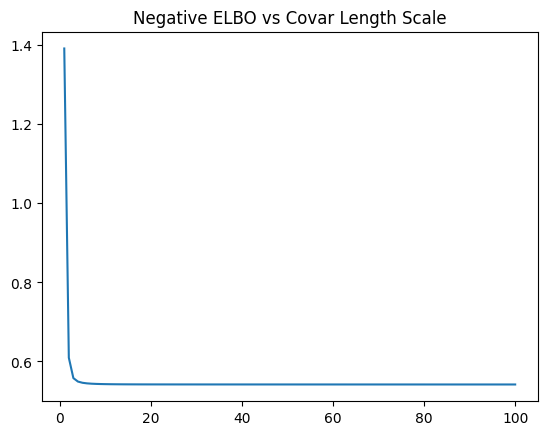

In [20]:
print(losses)

plt.plot(ll, losses)
plt.title('Negative ELBO vs Covar Length Scale')
plt.show()

In [21]:
model.zero_grad()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0), beta=1.)
loss = -mll(model(train_x), train_y)

first_derivative = torch.autograd.grad(loss, model.covar_module.raw_lengthscale, create_graph=True)[0]
second_derivative = torch.autograd.grad(first_derivative, model.covar_module.raw_lengthscale)[0]

print(
    "first derivative {:.10f},".format(first_derivative.item()),
    "second derivative {:.10f}".format(second_derivative.item()),
)

first derivative -0.0000040618, second derivative 0.0000003862
